# Figure Generation for Manuscript

## Overview
This notebook outlines the generation of **Supplementary Figure S9** for the manuscript. Detailed steps, including data processing, clustering, visualization parameters, and export settings, are included to ensure reproducibility.

---

## **Supplementary Figure S9: RISK Analysis of the High-Energy Physics Citation Network**
### Description
Supplementary Figure S9 illustrates RISK’s **interdisciplinary applicability** by analyzing a **high-energy physics citation network**, comprising **20,147 nodes and 331,044 edges** (Gehrke et al., 2003; Leskovec et al., 2005; Leskovec et al., 2014).

- **(A)** Visualization of the citation network using the **ForceAtlas2 layout** (Jacomy et al., 2014), where nodes represent **publications** and edges denote **citation relationships**.
- **(B)** RISK identified **eight distinct clusters** using the **Leiden algorithm** (Traag et al., 2019), corresponding to **research subfields** such as:
  - **Quantum mechanics**
  - **Particle physics**
  - **Condensed matter physics**
  - **Cosmology**
- Thematic overlaps were observed between closely related domains, e.g., **general relativity** and **cosmology**.
- **(C)** Journal-level annotation analysis showed **minimal correlation** between co-citation patterns and journal origin, suggesting that clusters reflect **thematic structure** more than publication source.  
  Example journals include:
  - *Progress of Theoretical Physics* (red cluster)
  - *Classical and Quantum Gravity* (blue cluster)

### Generation Steps
1. Load the **high-energy physics citation network** dataset.
2. Apply **RISK** using the **Leiden algorithm** to detect thematic clusters.
3. Visualize the network with **ForceAtlas2**, color-coded by cluster.
4. Analyze **cluster content** and highlight **thematic overlaps** and **journal metadata**.
5. Export the figure in **high-resolution formats** (SVG, PNG) for publication.

---

## Workflow
- **Input Data**: High-energy physics citation network (Gehrke et al., 2003; Leskovec et al., 2005, 2014).
- **Tools Used**: Python, RISK, NetworkX, ForceAtlas2 (via Gephi or fa2), Matplotlib/Seaborn.
- **Output**: Publication-ready figure for **Supplementary Figure S9**.


In [1]:
# First, extract snippets from article abstracts and determine their subfield(s)

import gzip
import pickle
import requests
import tarfile
import io
import re
import matplotlib.pyplot as plt
import networkx as nx
import random
from collections import defaultdict


# Enhanced function to extract the journal reference from the abstract content
def extract_journal_ref(text, citation):
    journals = defaultdict(list)
    # Updated pattern to capture journal names, including multi-word names with spaces and periods
    journal_pattern = r"Journal-ref:\s*([A-Za-z0-9\.\s\-]+)"

    # Search for the Journal-ref field
    journal_match = re.search(journal_pattern, text)
    if journal_match:
        # Extract the full journal reference string
        journal_ref = journal_match.group(1).strip()

        # Extract only words ending with a period, conjoining them into a single key
        words_with_periods = re.findall(r"[A-Za-z]+\.", journal_ref)
        # Don't add single period abbr
        if words_with_periods and len(words_with_periods) > 1:
            # Join the words, remove spaces, and create a compact key
            journal_name = "".join(words_with_periods).strip()
            journals[journal_name].append(citation)

    return journals


# The dictionary of subfields with their respective keywords
subfield_keywords = {
    "String Theory": ["string", "brane", "superstring", "m-theory", "tachyon", "compact", "calabi"],
    "General Relativity": [
        "gravit",
        "spacetime",
        "horizon",
        "einstein",
        "schwarzschild",
        "geodesic",
    ],
    "Cosmology": [
        "cosmo",
        "inflation",
        "dark matter",
        "dark energy",
        "big bang",
        "multiverse",
        "redshift",
    ],
    "Quantum Mechanics": [
        "quant",
        "wavefunc",
        "superposit",
        "entangle",
        "decoher",
        "tunnel",
        "uncert",
    ],
    "Quantum Field Theory": [
        "gaug",
        "lagrang",
        "renormal",
        "symmetry",
        "feynman",
        "fermion",
        "boson",
    ],
    "Condensed Matter Physics": [
        "supercond",
        "bandgap",
        "quasipart",
        "phonon",
        "topolog",
        "fermi",
        "insulat",
    ],
    "Particle Physics": ["quark", "lepton", "gluon", "colli", "neutrino", "higgs", "hadron"],
    "Nuclear Physics": ["fus", "fission", "nucleon", "deuteron", "isotope", "heavy ion", "neutron"],
}


# Check if any of the subfield-specific keywords appear in the text
def find_subfield_matches_in_text(subfield_keywords, text, citation):
    matches = defaultdict(list)
    for subfield, keywords in subfield_keywords.items():
        for keyword in keywords:
            if keyword.lower() in text.lower():
                matches[subfield].append(citation)
                break
    return matches


# Process an abstract based on mode (either 'subfield_citations' or 'journal')
def process_abstract(file_content, citation, mode="subfield_citations"):
    if mode == "subfield_citations":
        return find_subfield_matches_in_text(subfield_keywords, file_content, citation)
    elif mode == "journal":
        return extract_journal_ref(file_content, citation)


# Stream and process the tar.gz file for abstracts based on mode
def stream_and_process_tar_gz(url, mode="subfield_citations"):
    response = requests.get(url, stream=True)
    result_map = defaultdict(list)

    if response.status_code == 200:
        file_like_object = io.BytesIO(response.raw.read())
        with tarfile.open(fileobj=file_like_object, mode="r:gz") as tar:
            for member in tar.getmembers():
                if member.isfile() and member.name.endswith(".abs"):
                    citation = member.name.split("/")[-1].replace(".abs", "")
                    file_content = tar.extractfile(member).read().decode("utf-8")

                    # Process abstract based on the specified mode
                    processed_data = process_abstract(file_content, citation, mode)

                    # Update result_map with processed data
                    for key, citations in processed_data.items():
                        result_map[key].extend(citations)

    return result_map


# URL for the abstracts (cit-HepTh)
abstracts_url = "https://snap.stanford.edu/data/cit-HepTh-abstracts.tar.gz"

# Process the abstracts and aggregate citations by subfield
subfield_citations_map = stream_and_process_tar_gz(abstracts_url)

# Test the updated function with mode 'journal'
journal_citations_map = stream_and_process_tar_gz(abstracts_url, mode="journal")

# # Output the mapping of subfields to citations
# for subfield, citations in subfield_citations_map.items():
#     print(f"{subfield}: {citations}")

In [2]:
# Build citation network from citation file


def stream_and_build_network(url):
    G = nx.Graph()
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        gzip_file = io.BytesIO(response.content)
        with gzip.GzipFile(fileobj=gzip_file) as f:
            for line in f:
                decoded_line = line.decode("utf-8")
                if not decoded_line.startswith("#"):
                    parts = decoded_line.strip().split()
                    if len(parts) == 2:
                        from_node, to_node = parts
                        G.add_edge(from_node, to_node)
    return G


citation_url = "https://snap.stanford.edu/data/cit-HepTh.txt.gz"
print("Building graph...")
# Build the citation graph
citation_graph = stream_and_build_network(citation_url)

Building graph...


In [3]:
# Function to remove nodes with fewer than N edges


def remove_low_degree_nodes(G, min_edges=1):
    """
    Remove nodes from the graph that have fewer than min_edges edges.

    Args:
        G (nx.Graph): The input graph.
        min_edges (int, optional): Minimum number of edges for a node to remain. Defaults to 1.

    Returns:
        G (nx.Graph): The pruned graph.
    """
    nodes_to_remove = [node for node, degree in G.degree() if degree < min_edges]
    G.remove_nodes_from(nodes_to_remove)
    return G


# Function to sample N nodes from the graph and return a subgraph
def sample_graph(G, num_nodes):
    """
    Sample a subgraph with a specified number of nodes.

    Args:
        G (nx.Graph): The original graph.
        num_nodes (int): The number of nodes to sample.

    Returns:
        G_sampled (nx.Graph): The sampled subgraph.
    """
    sampled_nodes = random.sample(list(G.nodes()), min(num_nodes, G.number_of_nodes()))
    G_sampled = G.subgraph(sampled_nodes)
    return G_sampled

Num nodes before pruning for min edge count: 27770
Num nodes after pruning for min edge count: 20157


100%|██████████████████████████████████████████████████████████████████| 250/250 [02:52<00:00,  1.45it/s]


BarnesHut Approximation  took  50.05  seconds
Repulsion forces  took  108.98  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  8.77  seconds
AdjustSpeedAndApplyForces step  took  2.38  seconds


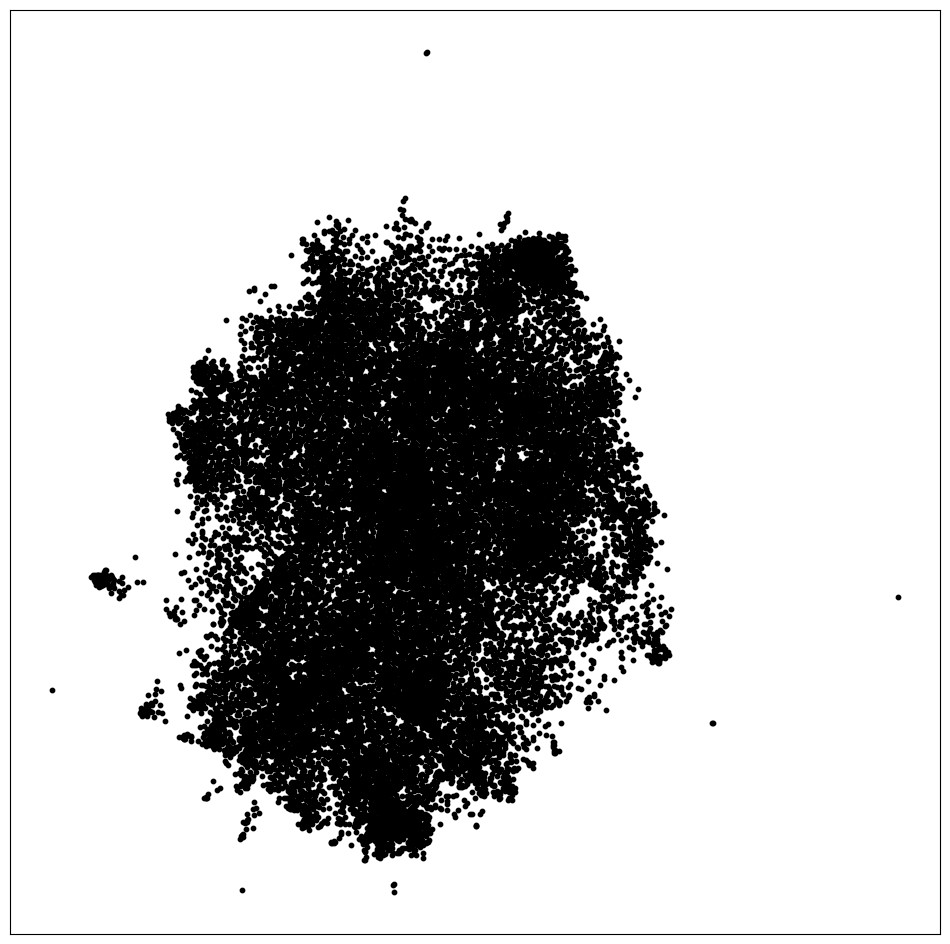

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
from fa2_modified import ForceAtlas2
import numpy as np
import random

random.seed(8)
np.random.seed(8)


def apply_forceatlas2_layout(
    G,
    iterations: int = 200,
    outbound_attraction_distribution: bool = False,
    lin_log_mode: bool = False,
    adjust_sizes: bool = False,
    edge_weight_influence: float = 1.0,
    jitter_tolerance: float = 1.0,
    barnes_hut_optimize: bool = True,
    barnes_hut_theta: float = 1.2,
    scaling_ratio: float = 2.0,
    strong_gravity_mode: bool = False,
    gravity: float = 1.0,
    verbose: bool = True,
):
    """
    Apply the ForceAtlas2 layout to a NetworkX graph G and update each node's 'pos' attribute with 'x' and 'y'.

    Args:
        G (networkx.Graph): The graph to layout.
        iterations (int): Number of iterations to run the ForceAtlas2 algorithm (default: 200).
        outbound_attraction_distribution (bool): Distribute attraction along outbound edges (default: False).
        lin_log_mode (bool): Switch ForceAtlas2 to LinLog mode (default: False).
        adjust_sizes (bool): Adjust sizes to avoid overlaps (default: False).
        edge_weight_influence (float): Influence of edge weights (default: 1.0).
        jitter_tolerance (float): Speed of convergence (lower value gives a more precise but slower convergence, default: 1.0).
        barnes_hut_optimize (bool): Whether to use the Barnes-Hut approximation to speed up computation (default: True).
        barnes_hut_theta (float): Theta parameter for Barnes-Hut approximation (default: 1.2).
        scaling_ratio (float): Scaling ratio (default: 2.0).
        strong_gravity_mode (bool): Apply strong gravity (default: False).
        gravity (float): Gravity strength (default: 1.0).
        verbose (bool): If True, print progress during layout calculation (default: True).

    Returns:
        networkx.Graph: The graph with updated 'x' and 'y' coordinates in the 'pos' attribute of each node.
    """
    # Initialize ForceAtlas2 layout algorithm
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=outbound_attraction_distribution,
        # linLogMode=lin_log_mode,
        adjustSizes=adjust_sizes,
        edgeWeightInfluence=edge_weight_influence,
        jitterTolerance=jitter_tolerance,
        barnesHutOptimize=barnes_hut_optimize,
        barnesHutTheta=barnes_hut_theta,
        scalingRatio=scaling_ratio,
        strongGravityMode=strong_gravity_mode,
        gravity=gravity,
        verbose=verbose,
    )

    # Extract node positions as a list of dictionaries
    pos = forceatlas2.forceatlas2_networkx_layout(
        G, pos=None, iterations=iterations, weight_attr="weight"
    )

    return pos


# Remove nodes with less than N edges
print(f"Num nodes before pruning for min edge count: {len(citation_graph.nodes())}")
G = remove_low_degree_nodes(citation_graph.copy(), min_edges=7)
print(f"Num nodes after pruning for min edge count: {len(G.nodes())}")

# # Sample 10,050 nodes from the large graph
# G_sampled = sample_graph(G, 15_150)
# Or just copy the whole graph
G_sampled = G.copy()

# Iteration count
iterations = 250

# Generate ForceAtlas2 layout for the sampled graph
pos = apply_forceatlas2_layout(
    G_sampled,
    iterations=iterations,
    outbound_attraction_distribution=False,
    adjust_sizes=False,
    edge_weight_influence=0.005,
    jitter_tolerance=1.0,
    barnes_hut_optimize=True,
    barnes_hut_theta=1.25,
    scaling_ratio=1.0,
    strong_gravity_mode=True,
    gravity=0.05,
    verbose=True,
)

# Draw the sampled graph without edges
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_sampled, pos, node_size=10, node_color="black")
plt.show()

In [5]:
random.seed(888)


# Function to add node positions to the graph as attributes
def add_positions_to_nodes(G, pos):
    """
    Add position information as node attributes.

    Args:
        G (nx.Graph): The input graph.
        pos (dict): A dictionary of node positions (from a layout algorithm).
    """
    for node, position in pos.items():
        G.nodes[node]["pos"] = position


# Add the positions to the nodes in the sampled graph
add_positions_to_nodes(G_sampled, pos)

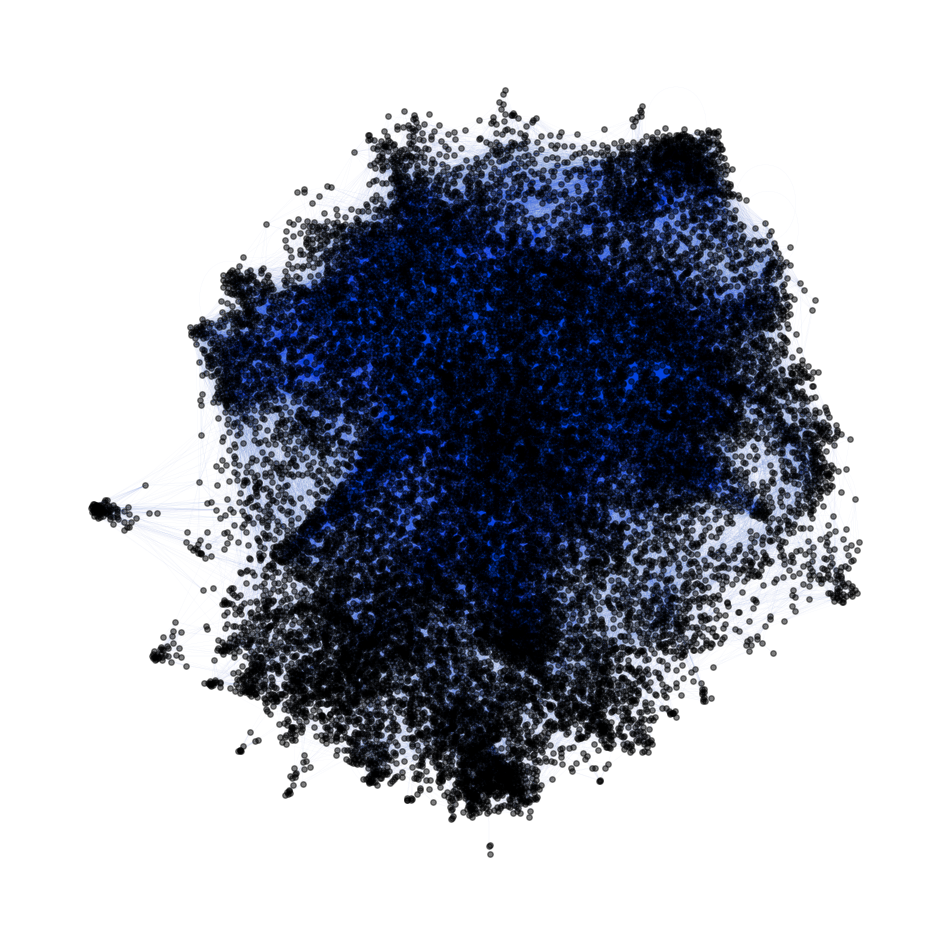

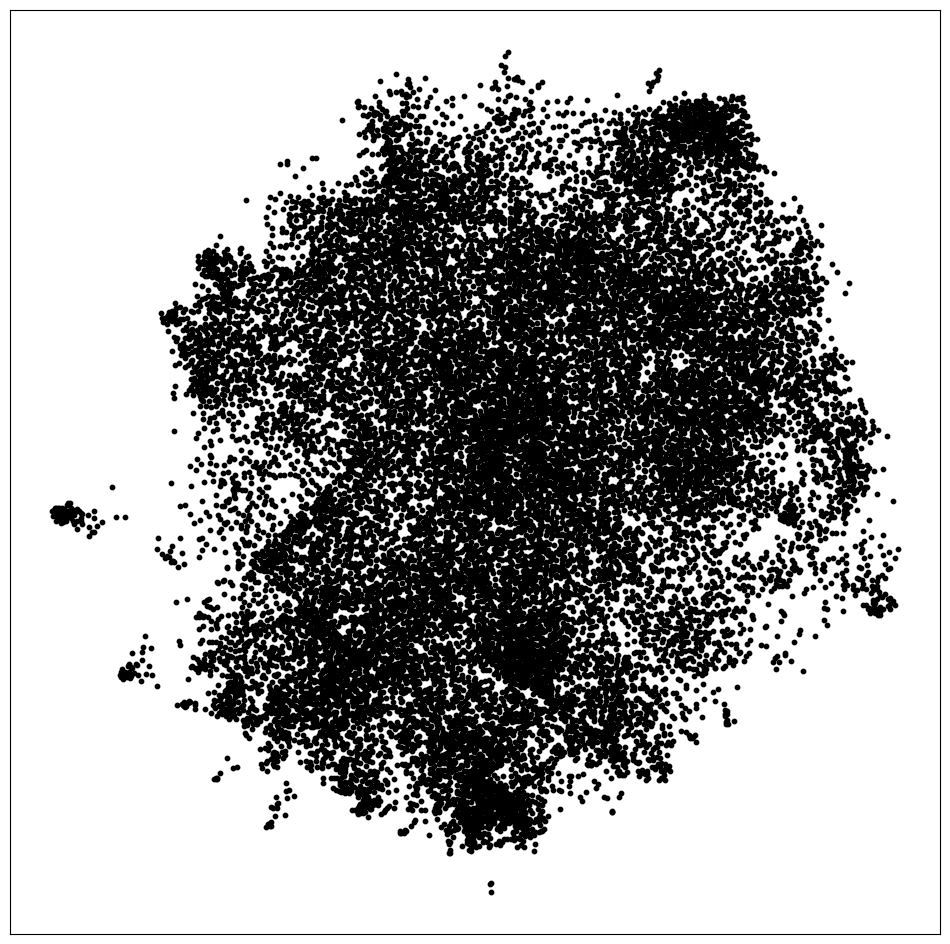

In [6]:
# Function to remove N nodes farthest from the centroid of the graph


def remove_farthest_from_centroid(G, positions, N=10):
    # Calculate the centroid of the graph (average position of all nodes)
    centroid = np.mean(list(positions.values()), axis=0)

    # Calculate the Euclidean distance of each node from the centroid
    distances_from_centroid = {
        node: np.linalg.norm(np.array(pos) - centroid) for node, pos in positions.items()
    }

    # Sort nodes by distance from the centroid and take the N farthest nodes
    farthest_nodes = sorted(distances_from_centroid, key=distances_from_centroid.get, reverse=True)[
        :N
    ]

    # Remove the farthest nodes from the graph
    G_removed = G.copy()
    G_removed.remove_nodes_from(farthest_nodes)

    # Remove positions of the farthest nodes, but only for nodes still in the graph
    positions_removed = {node: pos for node, pos in positions.items() if node in G_removed.nodes()}

    # Add 'x' and 'y' attributes for the remaining nodes
    for node, pos in positions_removed.items():
        G_removed.nodes[node]["x"] = pos[0]
        G_removed.nodes[node]["y"] = pos[1]

    # Add edge weights if they exist in the original graph
    for u, v, data in G_removed.edges(data=True):
        if "weight" in G[u][v]:
            G_removed[u][v]["weight"] = G[u][v]["weight"]

    # Plot the remaining graph with updated positions
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(
        G_removed, positions_removed, node_size=15, node_color="xkcd:black", alpha=0.5
    )
    nx.draw_networkx_edges(G_removed, positions_removed, width=0.01, edge_color="xkcd:blue")
    plt.axis("off")
    plt.show()

    return G_removed, positions_removed


# Example usage: Remove the 80 nodes farthest from the centroid and update the graph
G_updated, pos_updated = remove_farthest_from_centroid(G_sampled, pos, N=10)

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G_updated, pos_updated, node_size=10, node_color="black")
plt.show()

In [7]:
# Save the graph to a gpickle file


def save_graph_as_gpickle(graph, file_path):
    """Saves a NetworkX graph as a gpickle file using pickle."""
    with open(file_path, "wb") as f:
        pickle.dump(graph, f)


# save_graph_as_gpickle(G_updated, './data/gpickle/20250117_high_energy_physics_citations.gpickle')

## Apply RISK to Network

### NOTE: Begin analysis here if you already have a satisfactory Gpickle file of the citation network above.

### Supplementary Figure S9.B: Annotate using Physics Subfields

- This example attempts to capture true relationships


In [1]:
import risk

print(risk.__version__)

0.0.11


In [9]:
# Initialize the RISK object
from risk import RISK

risk = RISK(verbose=True)

In [10]:
#  Sphere with 0 depth is the best for the citation network
network = risk.load_gpickle_network(
    "./data/gpickle/20250117_high_energy_physics_citations.gpickle",
    compute_sphere=True,
    surface_depth=0.0,
    min_edges_per_node=0,
)

# Load annotations
annotations = risk.load_dict_annotation(
    network=network,
    content=subfield_citations_map,
)

---------------
Loading network
---------------
Filetype: GPickle
Filepath: ./data/gpickle/20250117_high_energy_physics_citations.gpickle
Minimum edges per node: 0
Projection: Sphere
Surface depth: 0.0
20147 out of 20147 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.
Initial node count: 20147
Final node count: 20147
Initial edge count: 331044
Final edge count: 331009
-------------------
Loading annotations
-------------------
Filetype: Dictionary
Filepath: In-memory dictionary
Minimum number of nodes per annotation term: 2
Number of input annotation terms: 8
Number of remaining annotation terms: 8


In [11]:
# Perform annotation overrepresentation analysis by computing p-values for network neighborhoods using the permutation test

neighborhoods = risk.load_neighborhoods_by_permutation(
    network=network,
    annotations=annotations,
    distance_metric="leiden",
    leiden_resolution=2.0,
    fraction_shortest_edges=0.25,
    score_metric="stdev",
    null_distribution="network",
    num_permutations=1_000,
    random_seed=887,
    max_workers=6,  # Leverage multiple cores to speed up process - adjust accordingly to your machine's specs
)

------------------------
Running permutation test
------------------------
Neighborhood scoring metric: 'stdev'
Number of permutations: 1000
Maximum workers: 6
Null distribution: 'network'
Distance metric: 'leiden (resolution=2.0)'
Edge length threshold: 0.25
Random seed: 887


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.75it/s]


In [12]:
# Get the NetworkGraph object for plotting

graph = risk.load_graph(
    network=network,
    annotations=annotations,
    neighborhoods=neighborhoods,
    tail="right",
    pval_cutoff=0.001,
    fdr_cutoff=1.00,
    impute_depth=0,
    prune_threshold=0.1,
    linkage_criterion="off",
    linkage_method="auto",
    linkage_metric="auto",
    linkage_threshold="auto",
    min_cluster_size=10,
    max_cluster_size=100_000,
)

---------------------------------
Finding significant neighborhoods
---------------------------------
p-value cutoff: 0.001
FDR BH cutoff: 1.0
Significance tail: 'right' (enrichment)
------------------------
Processing neighborhoods
------------------------
Imputation depth: 0
Pruning threshold: 0.1
-----------------------
Finding top annotations
-----------------------
Min cluster size: 10
Max cluster size: 100000
-----------------------------------------
Optimizing distance threshold for domains
-----------------------------------------


Evaluating optimal linkage method and metric:   0%|                                     | 0/154 [00:00<?]

Error encountered. Skipping clustering and assigning 8 unique domains.


---------------
Loading plotter
---------------


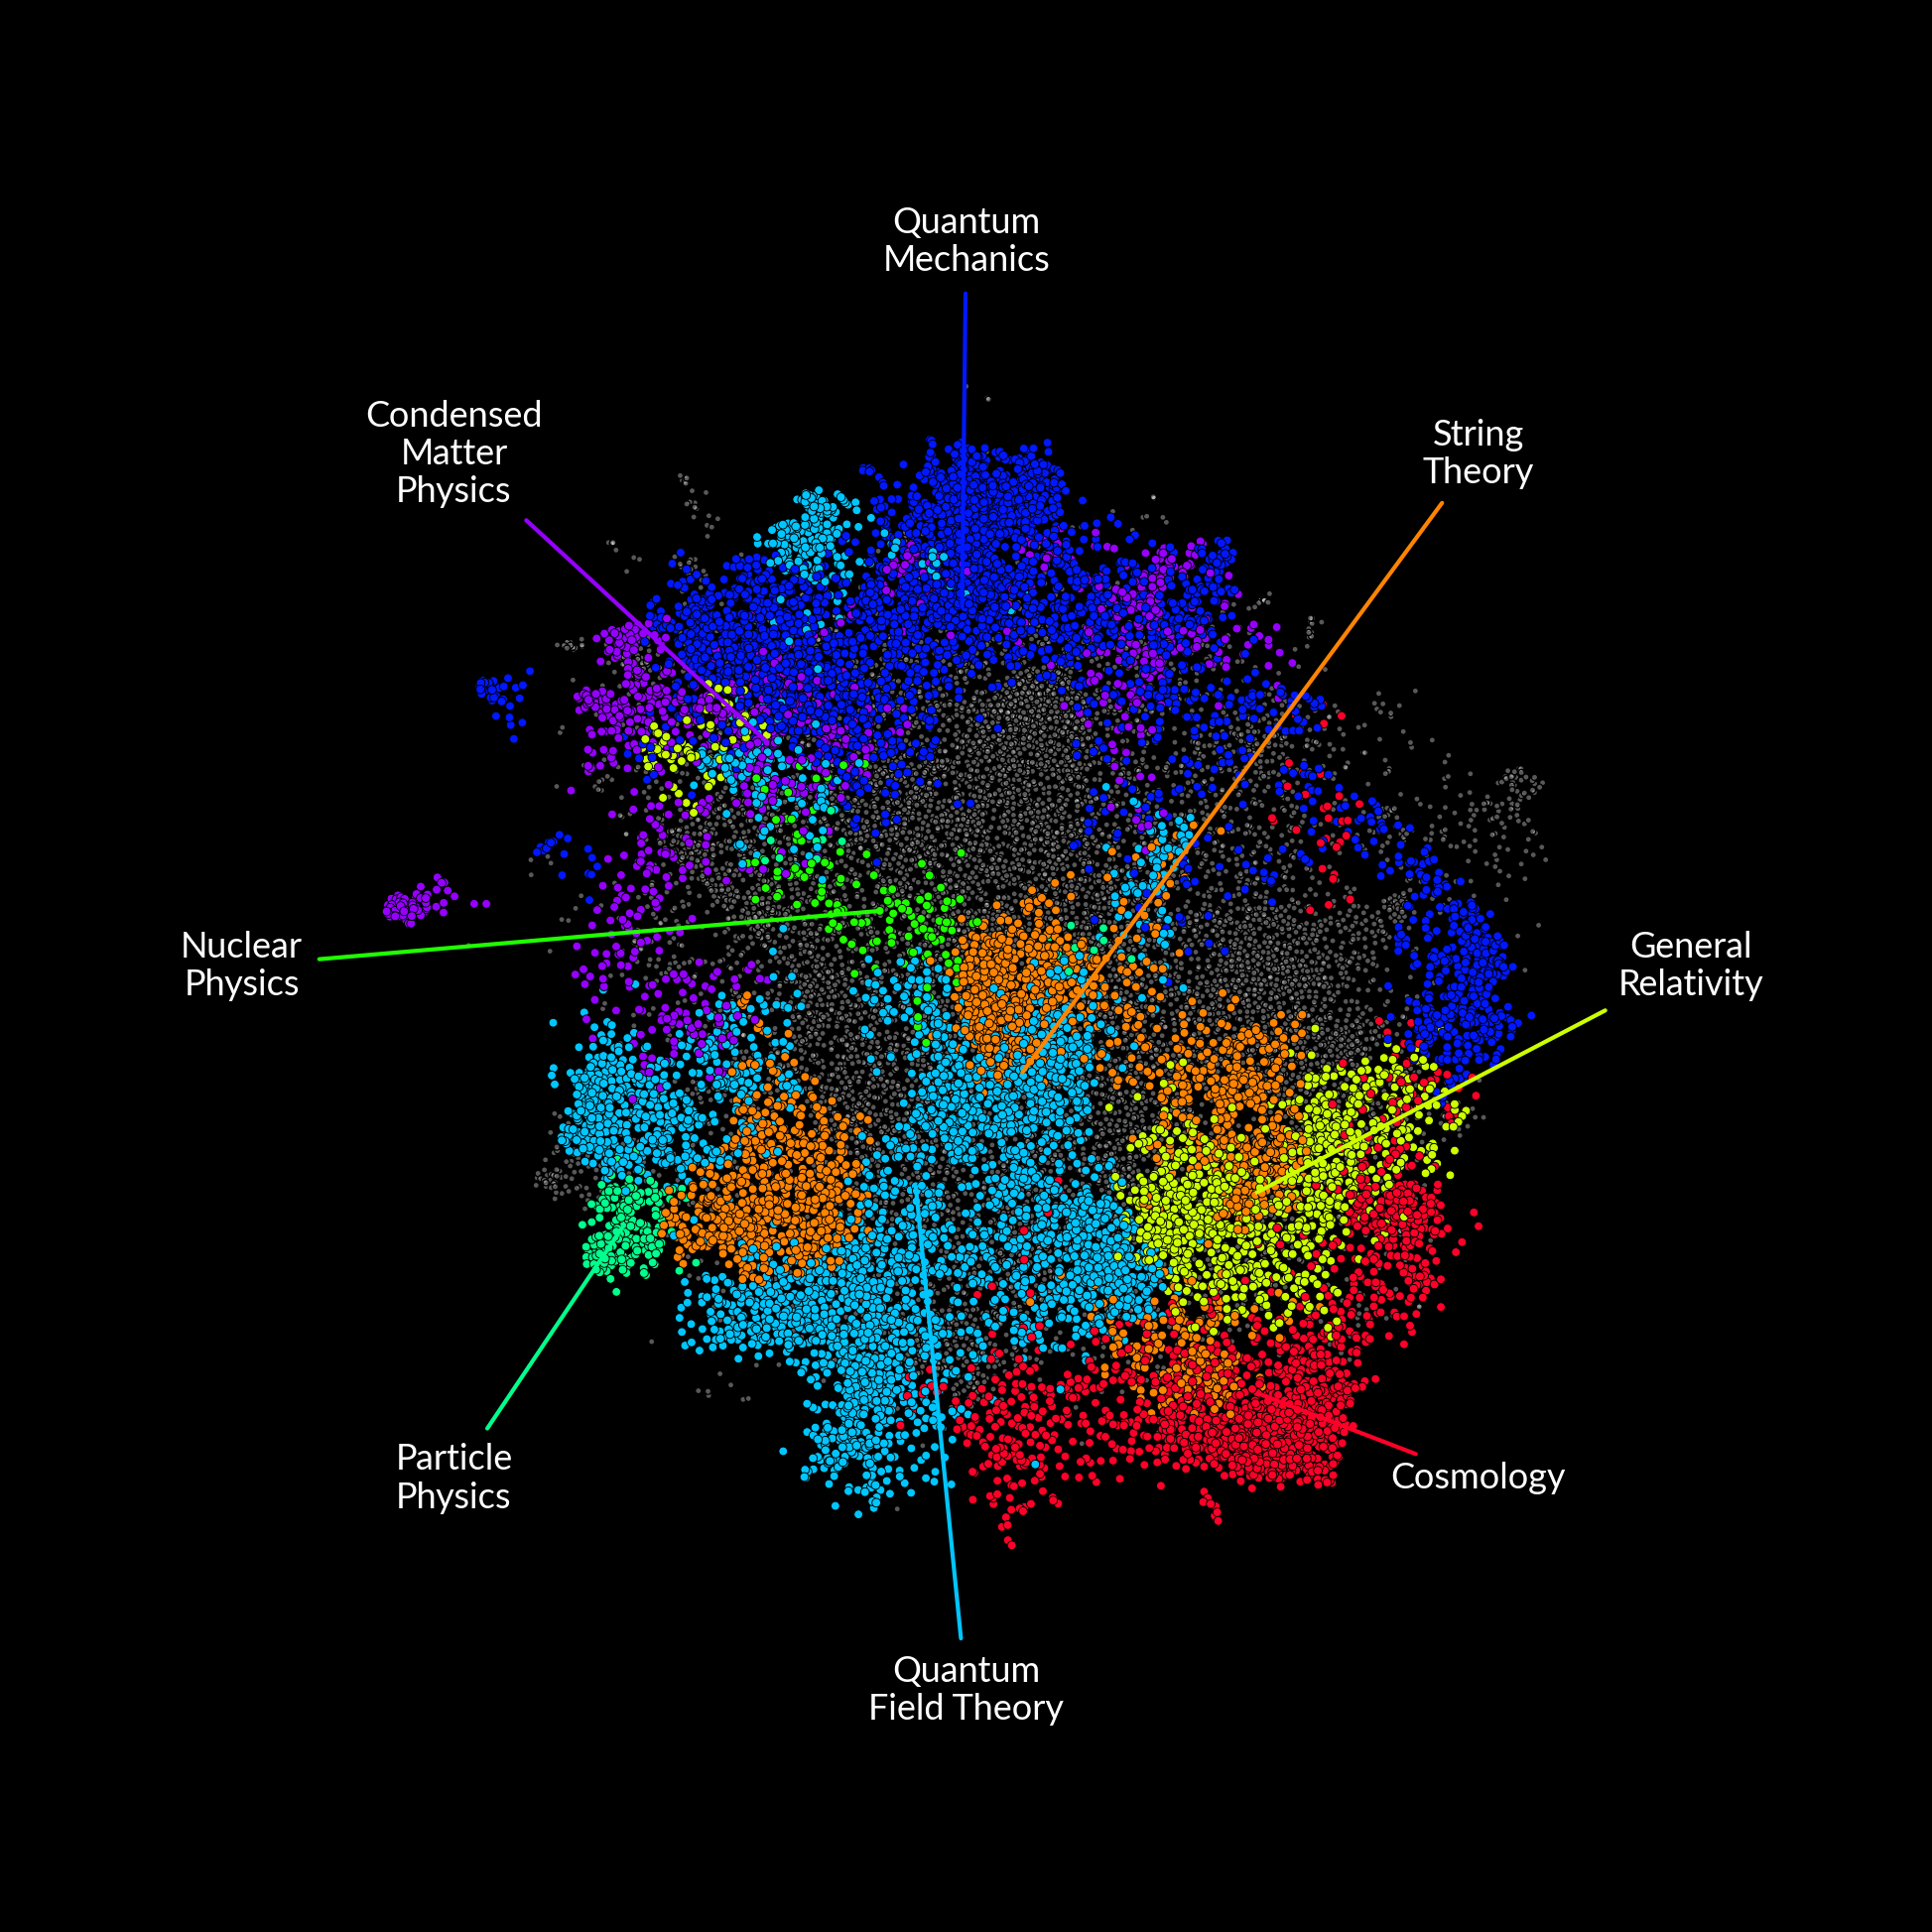

In [13]:
# Plot citations network with subfield annotations

random_seed = 866

# Initialize the NetworkPlotter with the NetworkGraph object
plotter = risk.load_plotter(
    graph=graph,
    figsize=(20, 20),
    background_color="black",
)

# Plot a subnetwork with custom node and edge attributes
plotter.plot_subnetwork(
    nodes=graph.node_id_to_node_label_map.values(),
    node_size=20,
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.00,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=0.35,
    edge_alpha=1.0,
)

# Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=40,
        nonsignificant_size=0,
    ),
    node_edgewidth=0.65,
    node_shape="o",
    edge_width=0.0,
    node_color=plotter.get_annotated_node_colors(
        cmap="gist_rainbow",
        # color="black",
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=1.0,
        alpha=1.0,
        blend_colors=False,
        nonsignificant_color="white",
        nonsignificant_alpha=0.5,
        random_seed=random_seed,
    ),
    # node_color="grey",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# Plot labels on the network
plotter.plot_labels(
    scale=1.05,
    offset=0.10,
    font="Lato",
    fontsize=26,
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=3,
    arrow_style="-",
    arrow_color=plotter.get_annotated_label_colors(
        cmap="gist_rainbow",
        color=None,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=1.0,
        random_seed=random_seed,
    ),
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
    max_labels=55,
    min_label_lines=1,
    max_label_lines=5,
    min_chars_per_line=1,
    max_chars_per_line=12,
    words_to_omit=None,
    overlay_ids=False,
    ids_to_keep=None,
)

# Finally, save and display the plot
# plotter.savefig("./png/publication/supp_fig_9b.png", dpi=350)

# Display the plot
plotter.show()

## Supplementary Figure S9.A

Empty high-energy physics citation network

---------------
Loading plotter
---------------


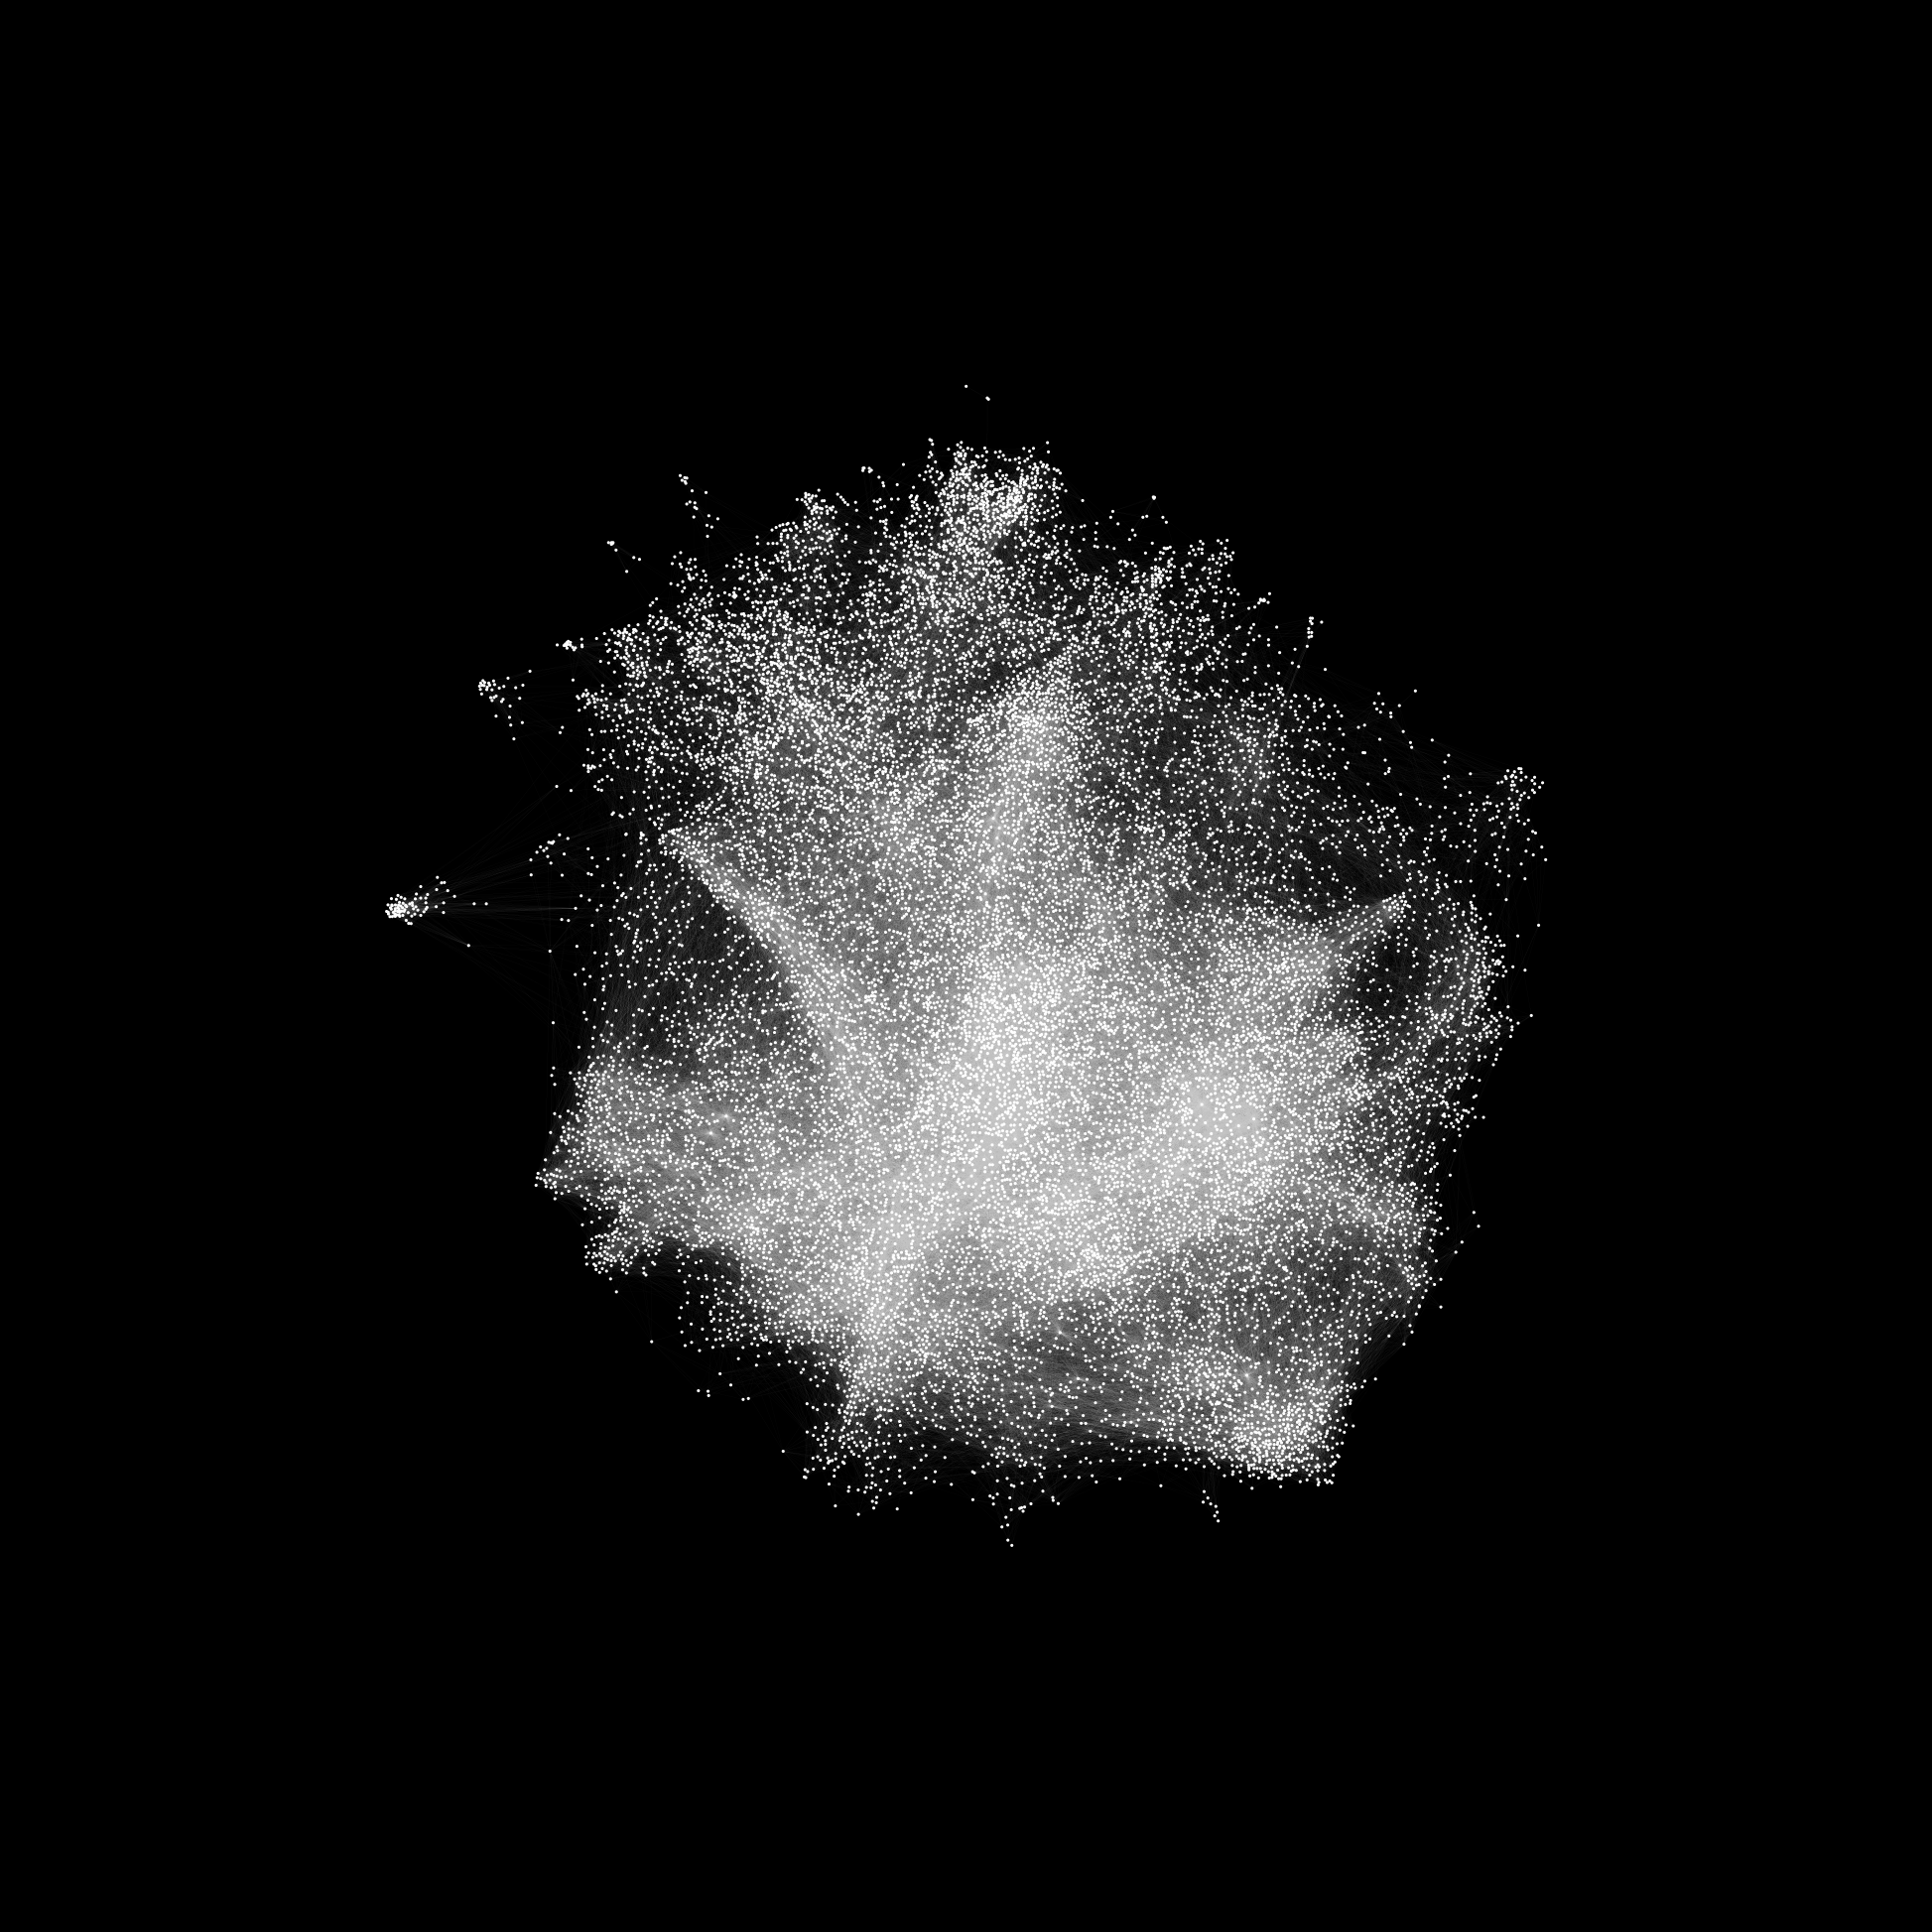

In [14]:
# Initialize the NetworkPlotter with the NetworkGraph object

random_seed = 866

plotter = risk.load_plotter(
    graph=graph,
    figsize=(20, 20),
    background_color="black",
)

# Optional: Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(significant_size=5, nonsignificant_size=5),
    edge_width=0.01,
    node_edgewidth=0.0,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_shape="o",
)

# Finally, save and display the plot
# plotter.savefig("./png/publication/supp_fig_9a.png", dpi=350)

plotter.show()

### Supplementary Figure S9.C: Annotate using Physics Subfields

- This example attempts to capture true relationships


In [15]:
import risk

print(risk.__version__)

0.0.9


In [16]:
# Initialize the RISK object

from risk import RISK

risk = RISK(verbose=False)

In [17]:
#  Sphere with 0 depth is the best for the citation network

network_journal = risk.load_gpickle_network(
    "./data/gpickle/20250117_high_energy_physics_citations.gpickle",
    compute_sphere=True,
    surface_depth=0.0,
    min_edges_per_node=0,
)

# Load annotations
annotations_journal = risk.load_dict_annotation(
    network=network_journal,
    content=journal_citations_map,
)

20147 out of 20147 nodes (100.00%) were missing 'label' attributes and were assigned node IDs.


In [18]:
# Perform annotation overrepresentation analysis by computing p-values for network neighborhoods using the permutation test

neighborhoods_journal = risk.load_neighborhoods_by_permutation(
    network=network_journal,
    annotations=annotations_journal,
    distance_metric="leiden",
    leiden_resolution=2.0,
    fraction_shortest_edges=0.25,
    score_metric="stdev",
    null_distribution="network",
    num_permutations=1_000,
    random_seed=887,
    max_workers=6,  # Leverage multiple cores to speed up process - adjust accordingly to your machine's specs
)

Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.42it/s]


In [28]:
# Get the NetworkGraph object for plotting

graph_journal = risk.load_graph(
    network=network_journal,
    annotations=annotations_journal,
    neighborhoods=neighborhoods_journal,
    tail="right",
    pval_cutoff=0.001,
    fdr_cutoff=1.00,
    impute_depth=0,
    prune_threshold=0.1,
    linkage_criterion="distance",
    linkage_method="complete",
    linkage_metric="hamming",
    linkage_threshold=0.251,
    min_cluster_size=10,
    max_cluster_size=100_000,
)

Evaluating optimal linkage method and metric: 100%|███████████████████████████████████| 1/1 [00:00<00:00]


Linkage criterion: 'distance'
Linkage method: 'complete'
Linkage metric: 'hamming'
Linkage threshold: 0.251


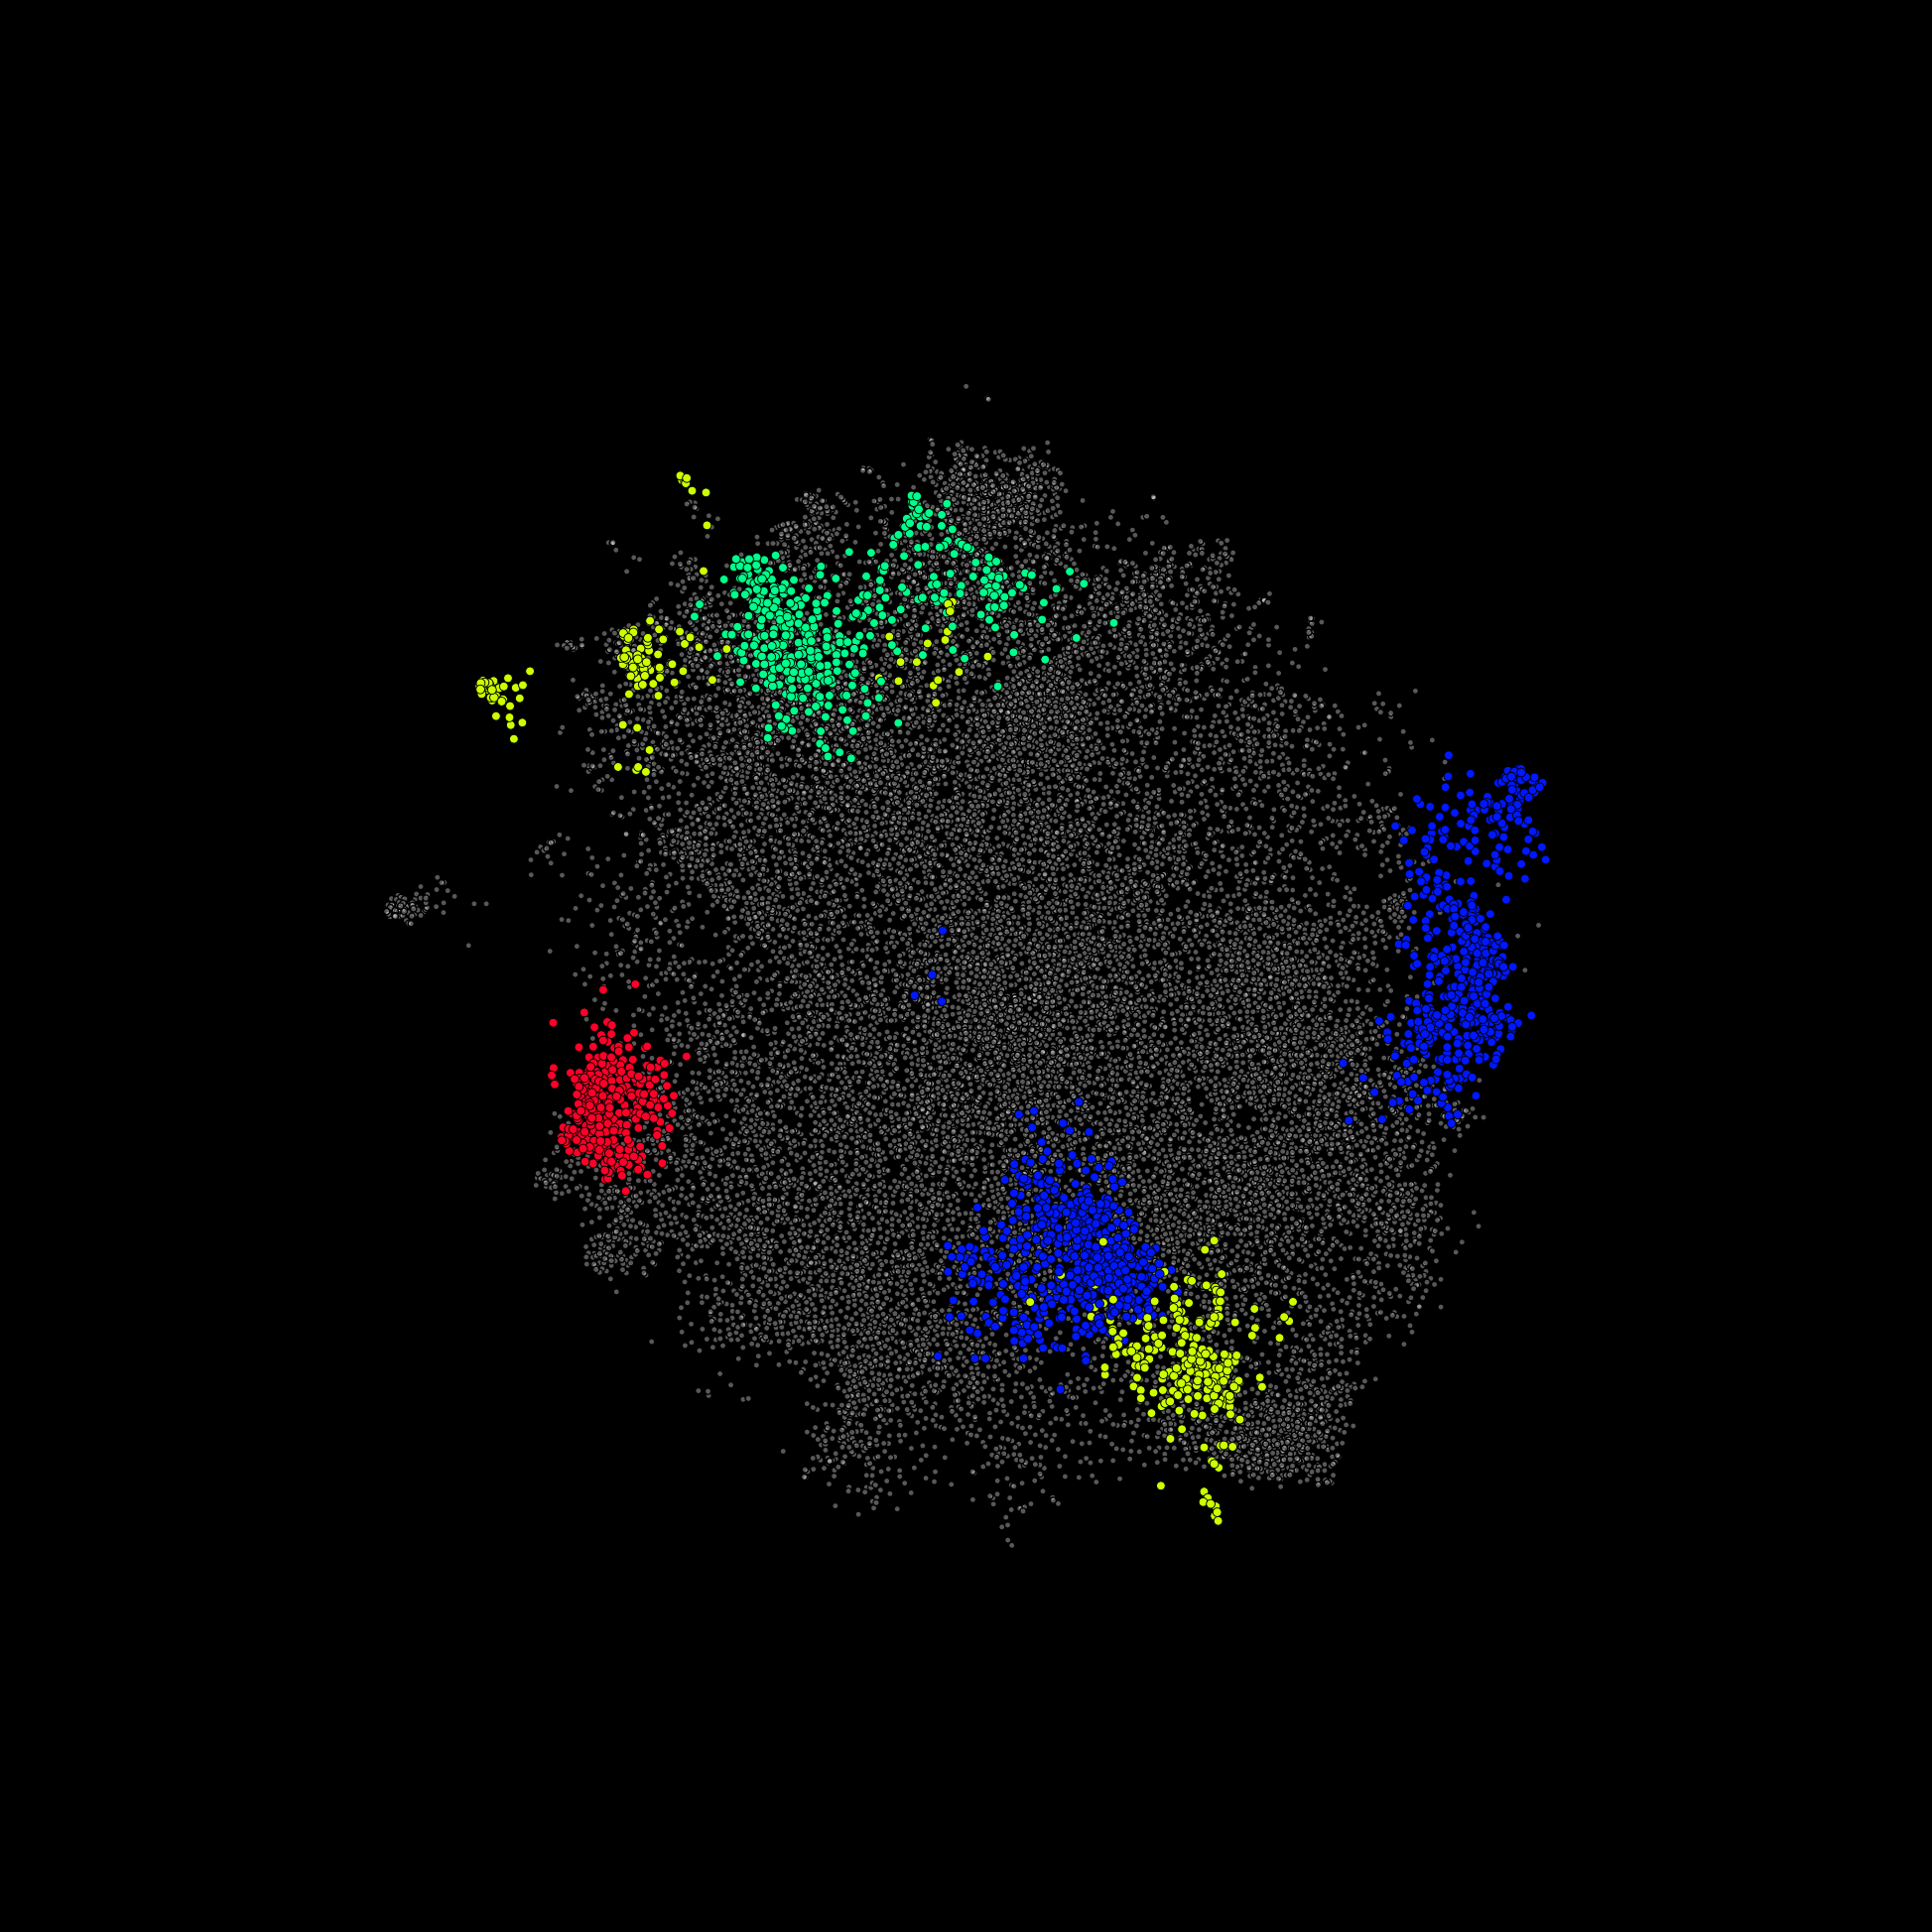

In [29]:
# Plot citations network with subfield annotations

random_seed = 866

# Initialize the NetworkPlotter with the NetworkGraph object
plotter_journal = risk.load_plotter(
    graph=graph_journal,
    figsize=(20, 20),
    background_color="black",
)

# Plot a subnetwork with custom node and edge attributes
plotter_journal.plot_subnetwork(
    nodes=graph.node_id_to_node_label_map.values(),
    node_size=20,
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.00,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=0.35,
    edge_alpha=1.0,
)

# Plot network nodes and edges
plotter_journal.plot_network(
    node_size=plotter_journal.get_annotated_node_sizes(
        significant_size=40,
        nonsignificant_size=0,
    ),
    node_edgewidth=0.65,
    node_shape="o",
    edge_width=0.0,
    node_color=plotter_journal.get_annotated_node_colors(
        cmap="gist_rainbow",
        # color="black",
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=1.0,
        alpha=1.0,
        blend_colors=False,
        nonsignificant_color="white",
        nonsignificant_alpha=0.5,
        random_seed=random_seed,
    ),
    # node_color="grey",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# Plot labels on the network
plotter_journal.plot_labels(
    scale=1.05,
    offset=0.10,
    font="Lato",
    fontsize=26,
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=3,
    arrow_style="-",
    arrow_color=plotter.get_annotated_label_colors(
        cmap="gist_rainbow",
        color=None,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=1.0,
        random_seed=random_seed,
    ),
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
    max_labels=55,
    min_label_lines=0,
    max_label_lines=0,
    min_chars_per_line=1,
    max_chars_per_line=12,
    words_to_omit=None,
    overlay_ids=False,
    ids_to_keep=None,
)


# Finally, save and display the plot
# plotter_journal.savefig("./png/publication/supp_fig_9c.png", dpi=350)

# Display the plot
plotter_journal.show()

In [30]:
# Print out all domain attribute terms

graph_journal.domain_id_to_domain_terms_map

{1: 'ClassQuantGrav',
 2: 'GravCosmol',
 3: 'AstropartPhys TheorMathPhys GenRelGrav PhysPolon CanJPhys JSuppl ReptMathPhys',
 4: 'ProgTheorPhysSuppl',
 5: 'JPhysSoc'}